In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import evaluator
from hwnas import main
import ast
from search_space import VGG8ModelSpaceCIFAR10
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch
from hwnas import hardware_aware_performance_estimation
from evaluator import test_epoch, train_epoch
import util
from collections import OrderedDict


In [2]:
df = pd.read_csv("../results.csv")
df = df.iloc[331:632]

df["metric"] = df.iloc[:,1:5].apply(lambda row: evaluator.objective(*row, w_acc=100, w_lat=1, w_en=1), axis=1)

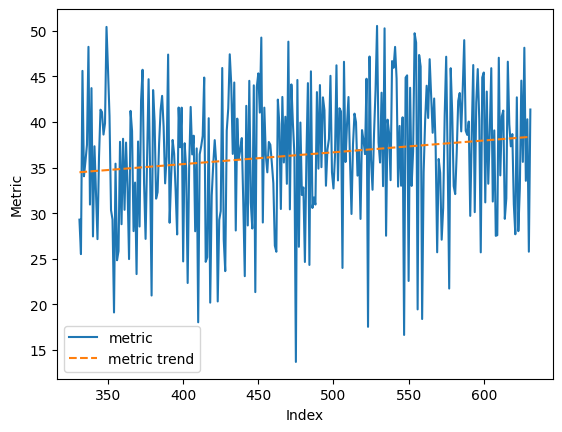

In [3]:
fig, ax = plt.subplots()

# Plot the raw data
ax.plot(df.index, df.metric, label='metric')
# ax.plot(df.index, df.energy, label='energy')

# Add trend line
df_with_index = df.reset_index()
model = sm.formula.ols(formula='metric ~ index', data=df_with_index)
res = model.fit()
ax.plot(df.index, res.fittedvalues, '--', label='metric trend')

ax.legend()
ax.set_xlabel('Index')
ax.set_ylabel('Metric')
plt.show()

In [ ]:
k = 10
top_k = df.sort_values('metric', ascending=False).head(k)
context_list = top_k['context'].tolist()
state_dicts = [{k: v for k, v in ast.literal_eval(d).items() if k != '__arch__'} for d in context_list]
state_dicts

[{'out_size_conv1': 32,
  'kernel_size_conv1': 5,
  'conv2_choice': 1,
  'channel_multiplier': 2,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 5,
  'conv4_choice': 0,
  'kernel_size_conv4': 3,
  'conv6_choice': 1,
  'pool_choice': 1},
 {'out_size_conv1': 16,
  'kernel_size_conv1': 7,
  'conv2_choice': 1,
  'channel_multiplier': 2,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 5,
  'conv4_choice': 1,
  'kernel_size_conv4': 5,
  'conv6_choice': 0,
  'pool_choice': 0},
 {'out_size_conv1': 64,
  'kernel_size_conv1': 3,
  'conv2_choice': 1,
  'channel_multiplier': 1.5,
  'kernel_size_conv2': 3,
  'conv3_choice': 1,
  'kernel_size_conv3': 3,
  'conv4_choice': 1,
  'kernel_size_conv4': 5,
  'conv6_choice': 0,
  'pool_choice': 0},
 {'out_size_conv1': 32,
  'kernel_size_conv1': 7,
  'conv2_choice': 1,
  'channel_multiplier': 1.5,
  'kernel_size_conv2': 3,
  'conv3_choice': 0,
  'kernel_size_conv3': 3,
  'conv4_choice': 0,
  'kernel_size_conv4': 5

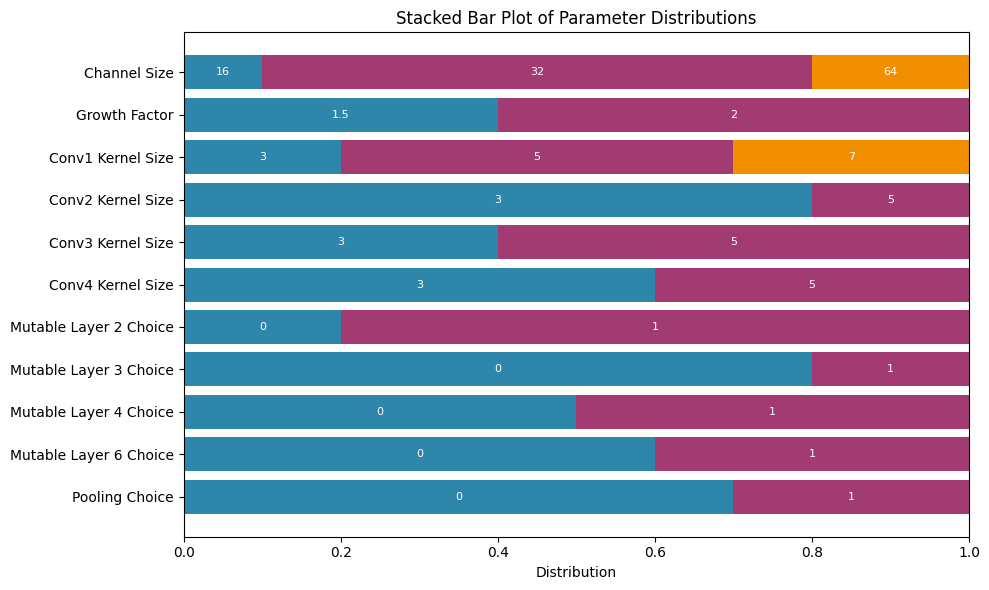

In [86]:
param_options, param_distr = main.combine_model_dict(state_dicts)

fig, ax = plt.subplots(figsize=(10, 6))


label_rename_map = {
    'pool_choice': 'Pooling Choice',
    'conv6_choice': 'Mutable Layer 6 Choice',
    'conv4_choice': 'Mutable Layer 4 Choice',
    'conv3_choice': 'Mutable Layer 3 Choice',
    'conv2_choice': 'Mutable Layer 2 Choice',
    'kernel_size_conv4': 'Conv4 Kernel Size',
    'kernel_size_conv3': 'Conv3 Kernel Size',
    'kernel_size_conv2': 'Conv2 Kernel Size',
    'kernel_size_conv1': 'Conv1 Kernel Size',
    'channel_multiplier': 'Growth Factor',
    'out_size_conv1': 'Channel Size'
}
order = list(label_rename_map.keys())

y_labels = list(param_options.keys())
y_pos = np.arange(len(y_labels))

params_ord = OrderedDict()

for key in order:
    params_ord.update({label_rename_map.get(key) : param_options.get(key)})
max_choices = max(len(v) for v in params_ord.values())
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592A37']
bottom = np.zeros(len(y_labels))


for choice_idx in range(max_choices):
    heights = []
    labels = []
    for key in order:
        param_values = params_ord[label_rename_map[key]]
        param_distribution = param_distr[key]
        if choice_idx < len(param_values):
            heights.append(param_distribution[choice_idx])
            labels.append(f"{param_values[choice_idx]}")
        else:
            heights.append(0)
            labels.append("")
    bars = ax.barh(y_pos, heights, left=bottom, label=f'Value: {labels[0] if labels.count(labels[0]) == len(labels) else f"Option {i}"}', color=colors[choice_idx % len(colors)],)

    for i, (bar, height, label) in enumerate(zip(bars, heights, labels)):
        # if height > 0.05:  # Only show labels for reasonably sized segments
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + bar.get_height()/2, 
                    label, 
                    ha='center', va='center', 
                    fontsize=8,
                    color='white')

    bottom += heights


ax.set_yticks(y_pos)
ax.set_yticklabels(list(params_ord.keys()))
ax.set_xlabel('Distribution')
ax.set_title('Stacked Bar Plot of Parameter Distributions')
# ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [62]:
model_space = VGG8ModelSpaceCIFAR10()
model = model_space.freeze(state_dicts[0])

In [ ]:
def evaluate_top_model(
    model,
    max_epochs=100,
    batch_size=128,
    num_workers=0,  # for Windows
    patience=15,
    min_delta=1,
    device="cuda",
    lr=0.01
):
    print("Architecture \n", model)
    counter=0
    best_metric=-np.inf
    util.replace_conv_bias_with_bn(module=model, device=device)
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    train_dataset, val_dataset = random_split(full_train, [45000, 5000])
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(max_epochs):
        print("Epoch", epoch)
        train_epoch(model, device, train_loader, optimizer)
        accuracy = test_epoch(model, device, val_loader)
        val_metric = accuracy
        if counter >= patience:
            print("Early stopping triggered")
            break
        if val_metric > best_metric + min_delta:
            best_metric = val_metric
            counter = 0
            print("Reset Patience")
        else:
            counter += 1
            
    test_accuracy = test_epoch(model, device, test_loader)
    print(f"Final Test Accuracy Digital: {test_accuracy:.2f}")
    print("Training done.")
    acc, lat, eng, area = hardware_aware_performance_estimation.get_hardware_metrics(model, train_loader=train_loader, test_loader=test_loader, val_loader=val_loader, num_classes=10, sim_config="../MNSIM-2.0/SimConfig.ini")
    final_metric = evaluator.objective(acc, lat, eng, area)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Latency: {lat:.4f}")
    print(f"Energy: {eng:.4f}")
    print(f"Area: {area:.4f}")
    print(f"Final Metric: {final_metric:.4f}")
    return final_metric, acc, lat, eng, area

In [59]:
evaluate_top_model(model)

Architecture 
 VGG8ModelSpaceCIFAR10(
  (conv1): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): DepthwiseSeparableConv(
    (conv1): Sequential(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv4): Sequential(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), st

Training:  75%|███████▌  | 265/352 [00:12<00:04, 20.90it/s]


KeyboardInterrupt: 